# Module 3 Project - Hyungjun Kang


## Northwind Database Hypothesis Testing

## Introduction

Module 3 project is about working with the Northwind Database. This project will demonstrate knowledges of SQL, designing and performing hypothesis testing. Northwind database is a sandbox databse made by Microsoft to demonstrate the SQL server and Microsoft Acesss. 

#### What to do with the Northwind database?

Utilizing the data, hypothesis testing was designed and conducted in order to maximize the comapny's profit. With differnt point of views towards the business model, total number of Four hypothesis was formed in order to give more insights. This will prevent product loss and maxize the revenue, lead to more profit for the company.


## Question 1.

### Test A: Does discount amount have a statistically significant effect on the quantity of a product in an order?



   - Null Hypothesis ($H_0$): Discount has no effect on the quntity of products sold.
   $$\mu_A = \mu_B$$


   - Alternative Hypothesis ($H_A$): Disccount has effect on the quantity of products sold.
   $$\mu_A \neq \mu_B$$   
   
   

In order to test the first hypothesis, the mean number of discounted product sold and the mean number of non-discounted prodcut sold needs to be calculated. If the mean number is the same, then it means that selling products with discounted price doesn't have help with increasing revenue. This is important question to ask to maximize company's profit. If the numbers of discounted item sold is larger, then further investigation will be performed to figure out at which level of the discount.


### EDA

Exploratory Data Analysis comes always first. 
Let's connect to the database and see what the enemy looks like.



Quick run-through was performed below.

#### Importing Libraries

In [330]:
# Importing more tools to get the job done

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sqlite3 as sql
import pandas as pd
import numpy as np
import scipy.stats as scs

from statsmodels.stats.power import TTestIndPower
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy import stats
from sklearn import linear_model as lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison



#### Connecting to database

In [331]:
conn = sql.Connection("Northwind_small.sqlite")   #Connecting to the data base
c = conn.cursor()

In [332]:
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall() #Fetching all the table names
tables = [i[0] for i in tables]



In [333]:
dfa = [] # Loop to put all tables into pandas dataframes
for i in tables:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
   
    category_name = i+"_df"
    exec(category_name + " = df") # => TableName_df
    
    dfa.append(category_name)
    
print(dfa)



['Employee_df', 'Category_df', 'Customer_df', 'Shipper_df', 'Supplier_df', 'Order_df', 'Product_df', 'OrderDetail_df', 'CustomerCustomerDemo_df', 'CustomerDemographic_df', 'Region_df', 'Territory_df', 'EmployeeTerritory_df']


Loop for tables
Source: https://github.com/arseniyturin/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb

In [334]:
OrderDetail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


It shows that there's no missing NaN or missing values. There're total 2155 data entries.

In [335]:
OrderDetail_df.head(10)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.00
1,10248/42,10248,42,9.8,10,0.00
2,10248/72,10248,72,34.8,5,0.00
3,10249/14,10249,14,18.6,9,0.00
4,10249/51,10249,51,42.4,40,0.00
5,10250/41,10250,41,7.7,10,0.00
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05


In [336]:
OrderDetail_df[['Quantity','Discount']].describe()

,Quantity,Discount
count,2155.000000,2155.000000
mean,23.812993,0.056167
std,19.022047,0.083450
min,1.000000,0.000000
25%,10.000000,0.000000
50%,20.000000,0.000000
75%,30.000000,0.100000
max,130.000000,0.250000


In [337]:
discount =  OrderDetail_df[OrderDetail_df['Discount']!=0]

no_discount =  OrderDetail_df[OrderDetail_df['Discount']==0]


In [338]:
discount.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 6 to 2152
Data columns (total 6 columns):
Id           838 non-null object
OrderId      838 non-null int64
ProductId    838 non-null int64
UnitPrice    838 non-null float64
Quantity     838 non-null int64
Discount     838 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 45.8+ KB


In [339]:
no_discount.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317 entries, 0 to 2154
Data columns (total 6 columns):
Id           1317 non-null object
OrderId      1317 non-null int64
ProductId    1317 non-null int64
UnitPrice    1317 non-null float64
Quantity     1317 non-null int64
Discount     1317 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 72.0+ KB


There're little total of 1317 of discounted products and 838 of non-discounted products.

In [340]:
discount.Quantity.describe()

count    838.000000
mean      27.109785
std       20.771439
min        1.000000
25%       12.000000
50%       20.000000
75%       36.000000
max      130.000000
Name: Quantity, dtype: float64

In [341]:
no_discount.Quantity.describe()

count    1317.000000
mean       21.715262
std        17.507493
min         1.000000
25%        10.000000
50%        18.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

In [342]:
discount['Discount'].unique()

array([0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [343]:
discount['Discount'].value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

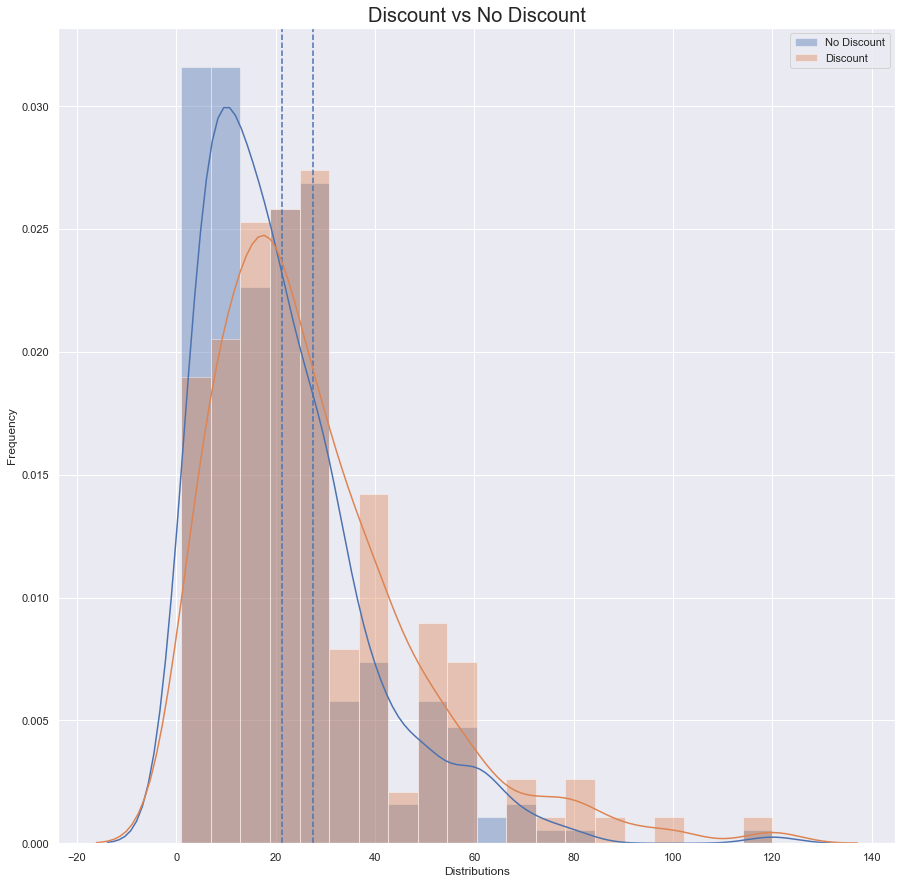

In [344]:
plt.axvline(x=s_ndc.mean(), linestyle='--')
plt.axvline(x=s_dc.mean(), linestyle='--')


sns.distplot(s_ndc, bins = 20, label= 'No Discount')
sns.distplot(s_dc, bins =20, label='Discount')

plt.title('Discount vs No Discount', fontsize=20)
plt.xlabel('Distributions')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Average product sold with discount = 27.110  Average product sold without discount 21.715


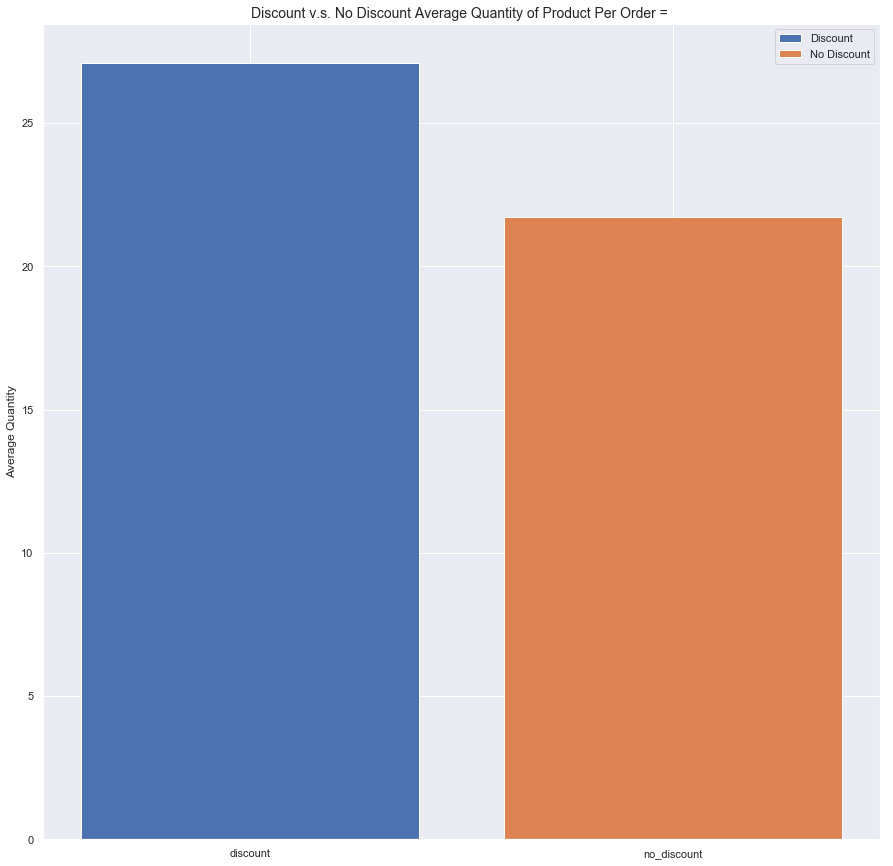

In [345]:
X1 = 'discount'
Y1 = discount.Quantity.mean()
X2 = 'no_discount'
Y2 = no_discount.Quantity.mean()

plt.bar(X1,Y1, label= 'Discount')
plt.bar(X2,Y2, label= 'No Discount')

plt.legend()
plt.ylabel('Average Quantity')
plt.title('Discount v.s. No Discount Average Quantity of Product Per Order = ', fontsize=14 )
print('Average product sold with discount = %.3f ' % Y1, 'Average product sold without discount %.3f' % Y2)

#### Things learned from the EDA

 - Total of 2155, discounted sample number = 838, not discounted sample = 1317.
 - Quantity data is not normally distributed by looking at the histogram, left scewed.
 - There're 5 different levels of discount.

### Which test to use for hypothesis testing?

To determine if there's difference between mean of the two groups, t-test can be used. By the definition from the source, "A t-test’s statistical significance indicates whether or not the difference between two groups’ averages most likely reflects a “real” difference in the population from which the groups were sampled." For this testing Welch's t-test will be used.

source: http://docs.statwing.com/examples-and-definitions/t-test/statistical-significance/

#### Assumptions for Welch’s T-test
Welch's T-test was chosen for this hypothesis testing because of the couple of the reasons. Welch's t-test doesn't have to have same number of samples and the variance between the sampe groups. Discounted group and non-discounted group has different number of samples. Let's see if two samples fulfils assumptions for welch's T-test

1. Random sample:

 All the data was independently drawn ones. It's not dependent to each other at all, so It meets the requirements.
 

2. Normal distribution:

 By the performing EDA, sample data doesn't have normal distribution. It's right skewed distribution. But, according to the central limit theorem, if the sample sizes are large enough, the distribution of means will follow a Gaussian distribution(normal distribution) even if the population is not Gaussian. Safe sample size to invoking this assumption is kwon as larger than 10 samples in the groups. Since there're way more than 10 samples for each groups, it is safe to invoke this assumption and proceed.
 

sourc:https://www.graphpad.com/guides/prism/7/statistics/the_central_limit_theorem_of_statistics.htm?toc=0&printWindow
 
 
3. Continuous dependent variable

 Dependant variable for the samples are continuous. It's not categorical.
 

#### It is safe to use Welch's T-test for the hypothesis number 1.

### Stastical Power

Right tool for the testing was choosen, but there's still antoher thing to be chosen for before the actual testing. It is the stastical power. It is one of the most importan thing for the hypothesis testing to get a valid result from the test. It shows how likely a test is to distinguish an actual effect from total random chance. For this hypothesis, alpha and  beta will be designated as following, until enough number of sample size is verified later.

$$\alpha = 0.05$$
$$\beta = 0.05$$
Confidencelevel = 95%
Power = 95%

Stastical power and confidence level will be both at 95%
In order to verify what sample size is required to have both of the confidence level and stastic power. 

Below is parameters for power analysis.

#### Cohen's D for calculating effect size for two group

In [346]:
# Function for calculating cohen's D for effect size
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return abs(d)

print('discounted vs non-discounted %.5f' % Cohen_d(discount.Quantity, no_discount.Quantity))

discounted vs non-discounted 0.28627


- small effect  = 0.2
- medium effect = 0.5 
- large effect  = 0.8 

It is already showing that there's small to medium effect on disccount on quantity of product sold between two grorups.

#### Calculating required sample size for 95% cofidence lvel with 95% statistical power

In [347]:
# parameters for power analysis
effect_size = 0.286 
alpha = 0.05
power = 0.95
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 318.698


Required sample size is 319 from each of the group. There're more than enough of samples are available to run the test. This hypothesis testing will have statistical power of 95% and 95% confidence level. It has high posibility of rejecting false null hypothesis and all posible samples that can be expected to include the ture population parameter. This is very strong statistically significant test.

Source: https://stattrek.com/statistics/dictionary.aspx?definition=confidence_level



#### Welch's t-test

In [348]:
# create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# combine functions to create a sample distribution
# create a distribution size of 320 and sample size of 320
def create_sample_distribution(df, dist_size=319, n=319):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
        
    return sample_dist

Source code is from the Learn.co Material
https://github.com/learn-co-curriculum/dsc-central-limit-theorem-lab/tree/solution

In [349]:
# create control and experimental groups
control = OrderDetail_df[OrderDetail_df['Discount'] == 0]
control = control['Quantity']
exp = OrderDetail_df[OrderDetail_df['Discount'] != 0]
exp = exp['Quantity']

In [350]:
ctrl_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(exp)

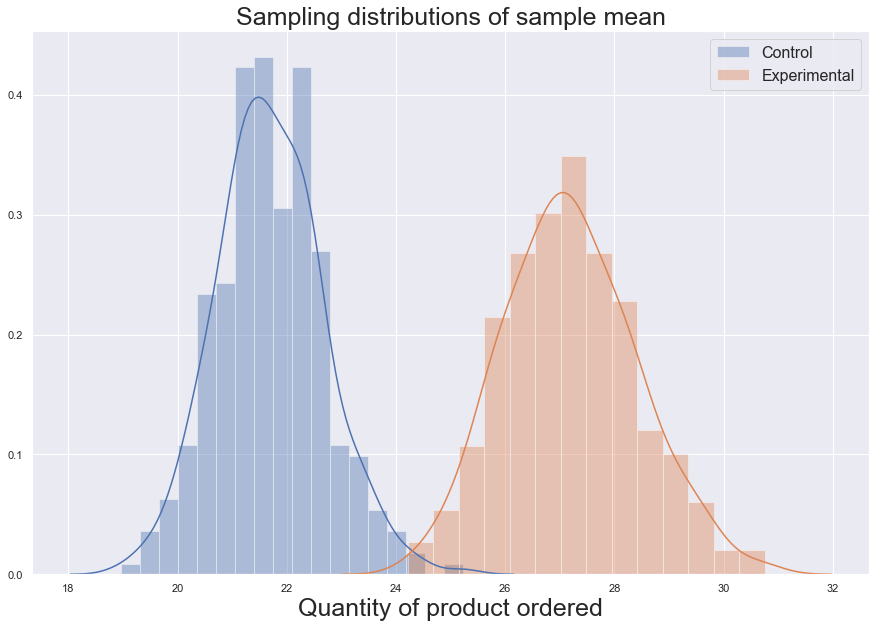

In [351]:
plt.figure(figsize = (15, 10))
sns.distplot(ctrl_sample, label='Control')
sns.distplot(exp_sample, label='Experimental')
plt.title('Sampling distributions of sample mean', fontsize=25)
plt.xlabel('Quantity of product ordered', fontsize=25)
plt.legend(fontsize=16)

In [352]:
s_ndc = no_discount.Quantity.sample(319)
s_dc = discount.Quantity.sample(319)

result = stats.ttest_ind(exp_sample, ctrl_sample, equal_var=False)

print(result)

Ttest_indResult(statistic=63.15667720367915, pvalue=1.729426788331189e-269)


### Conclusion for Test A

#### Reject null hypothesis and accept alternate hypothesis

P-value is less than 0.05. It's not likely to be a result of a random chance, and difference is significant. It is safe to reject the null hypotehsis and accept the alternate hypothesis. It was proven that there's effect on quantity sold when discount was applied to the products.

### Test B: At what levels of discount products get sold the most?



   - Null Hypothesis ($H_0$): There is no statistically significant difference between quntity sold with different levels of discount.
   $$\mu_A = \mu_B = \mu_C$$


   - Alternative Hypothesis ($H_A$): There's statistically significant difference between quantity sold with different levels of discount.
   $$\mu_A \neq \mu_B \neq \mu_C $$   
  
 

#### How many discount levels are there? 

In [353]:
len(discount['Discount'].unique())

10

### Which test to use for hypothesis testing?

There're 10 different levels of discounts and the testing is about if there's any difference between mean of quantity sold between products. ANOVA, Analysis of Varaiance might be the right one for this since there're more than two groups. But, there're requirements to meet first in order to use ANOVA. 

#### Assumptions for ANOVA Test
There are three assumptions for ANOVA test. Those are random samples, normal distribution, equal variance.

Let's tackle one at a time to exmaine ANOVA is the right tool.

1. Random sample:

 Already verified, all the data is from independent customers. There's no correlation or influence between customers.
 

2. Normal distribution:

 It's not normally distributed, but it can be invoked by the cnetral limit theroem with having sufficiently large sample size greater than 30.
 
 
3. Equal variance:

 To test equal variance, there're many ways to test it, but Levne's test is one of the easiest and well kwon method to test. If the p-value is larger than 0.05, then the variances are not significantly different from each other. Levene's test will perform to verify equal variance.
 



In [354]:
OrderDetail_df['Quantity'].groupby(OrderDetail_df['Discount']).describe



,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0


#### Performing Levene's test

In [361]:
zero = OrderDetail_df[OrderDetail_df['Discount'] == 0]
five =  OrderDetail_df[OrderDetail_df['Discount'] == .05]
ten =  OrderDetail_df[OrderDetail_df['Discount'] == .1]
fifteen= OrderDetail_df[OrderDetail_df['Discount'] == .15]
twenty =  OrderDetail_df[OrderDetail_df['Discount'] == .2]
twentyfive = OrderDetail_df[OrderDetail_df['Discount'] == .25]


scs.levene(zero.Quantity, five.Quantity, ten.Quantity, ten.Quantity, fifteen.Quantity, twenty.Quantity, twentyfive.Quantity)

LeveneResult(statistic=2.4652212047399273, pvalue=0.022233522937504416)

P-value turns out to be lessthan 0.05. Variances are different from each sample groups. AVNOA can't be performed.
Multiple comparison test will be performed to determine which discount levels have a statistically significant effect on the quantity of product sold.Tukey's HSD test will be performed.

In [390]:
#results =[]
#names = []

g = [five.Quantity, ten.Quantity, ten.Quantity, fifteen.Quantity, twenty.Quantity, twentyfive.Quantity]

for i in range(len(g) - 1):
    for j in range(i, len(g)):
        t, p = stats.ttest_ind(g[i], g[j], equal_var=False)
        print("T_Test between", i, "% and", j, '%. T Value = ', t, 'P Value =', p)

T_Test between 0 % and 0 %. T Value =  0.0 P Value = 1.0
T_Test between 0 % and 1 %. T Value =  1.209941058797434 P Value = 0.22710466225198522
T_Test between 0 % and 2 %. T Value =  1.209941058797434 P Value = 0.22710466225198522
T_Test between 0 % and 3 %. T Value =  -0.15907926596432054 P Value = 0.873701937770792
T_Test between 0 % and 4 %. T Value =  0.4470597476296268 P Value = 0.6551134299813659
T_Test between 0 % and 5 %. T Value =  -0.09976173385499833 P Value = 0.9205932482537716
T_Test between 1 % and 1 %. T Value =  0.0 P Value = 1.0
T_Test between 1 % and 2 %. T Value =  0.0 P Value = 1.0
T_Test between 1 % and 3 %. T Value =  -1.3556023920391185 P Value = 0.17616507980479174
T_Test between 1 % and 4 %. T Value =  -0.8162459699699015 P Value = 0.414945941918507
T_Test between 1 % and 5 %. T Value =  -1.3140624458315409 P Value = 0.1897558400462687
T_Test between 2 % and 2 %. T Value =  0.0 P Value = 1.0
T_Test between 2 % and 3 %. T Value =  -1.3556023920391185 P Value = 0

All the P-values are larger than 0.05. There's no effects between the disccount amount.

### Conclusion for Test B : There was no difference between discount levels.

## Question 2. 
   ### Does different shipper have different frieght cost ?
   
    
   - Null Hypothesis ($H_0$): There is no significant frieght cost difference from the shippers.
   $$\mu_A = \mu_B = \mu_C$$

   - Alternative Hypothesis ($H_1$): There's significant friehgt cost difference from the shipppers.
   $$\mu_A \neq \mu_B \neq \mu_C$$   
   
  Again, EDA comes first.

### EDA

Exploratory Data Analysis comes always first.
Let's connect to the database and see what the enemy looks like.



Quick run-through was performed below.

In [365]:
#Query for loading the data for hypothesis testing number two.

query = """ 
SELECT 
    s.CompanyName, o.Freight
FROM 
    [Shipper] s
    JOIN
    [Order] o
    ON 
    o.ShipVia = s.Id
"""

ship_df = pd.read_sql_query(query, conn) 
fed_df = ship_df.loc[ship_df.CompanyName == 'Federal Shipping']
speed_df = ship_df.loc[ship_df.CompanyName == 'Speedy Express']
united_df = ship_df.loc[ship_df.CompanyName == 'United Package']

print(ship_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 2 columns):
CompanyName    830 non-null object
Freight        830 non-null float64
dtypes: float64(1), object(1)
memory usage: 13.0+ KB
None


In [366]:
print(ship_df.head(10)) #First 10 data from the query

        CompanyName  Freight
0  Federal Shipping    32.38
1    Speedy Express    11.61
2    United Package    65.83
3    Speedy Express    41.34
4    United Package    51.30
5    United Package    58.17
6    United Package    22.98
7  Federal Shipping   148.33
8    United Package    13.97
9  Federal Shipping    81.91


In [367]:
print(ship_df.describe())  #Quick stat info

           Freight
count   830.000000
mean     78.244205
std     116.779294
min       0.020000
25%      13.380000
50%      41.360000
75%      91.430000
max    1007.640000


In [368]:
print(ship_df.groupby('CompanyName').describe()) #Quick stastical data from the each company

                 Freight                                                     \
                   count       mean         std   min    25%     50%    75%   
CompanyName                                                                   
Federal Shipping   255.0  80.441216  119.362844  0.40  12.86  36.710  99.49   
Speedy Express     249.0  65.001325   75.393587  0.12  12.75  40.420  89.90   
United Package     326.0  86.640644  138.219262  0.02  14.04  44.135  91.43   

                           
                      max  
CompanyName                
Federal Shipping  1007.64  
Speedy Express     458.78  
United Package     890.78  


Let's take a look at the data distribution. Normaly distributed sample is required for most of the hypothesis test. 

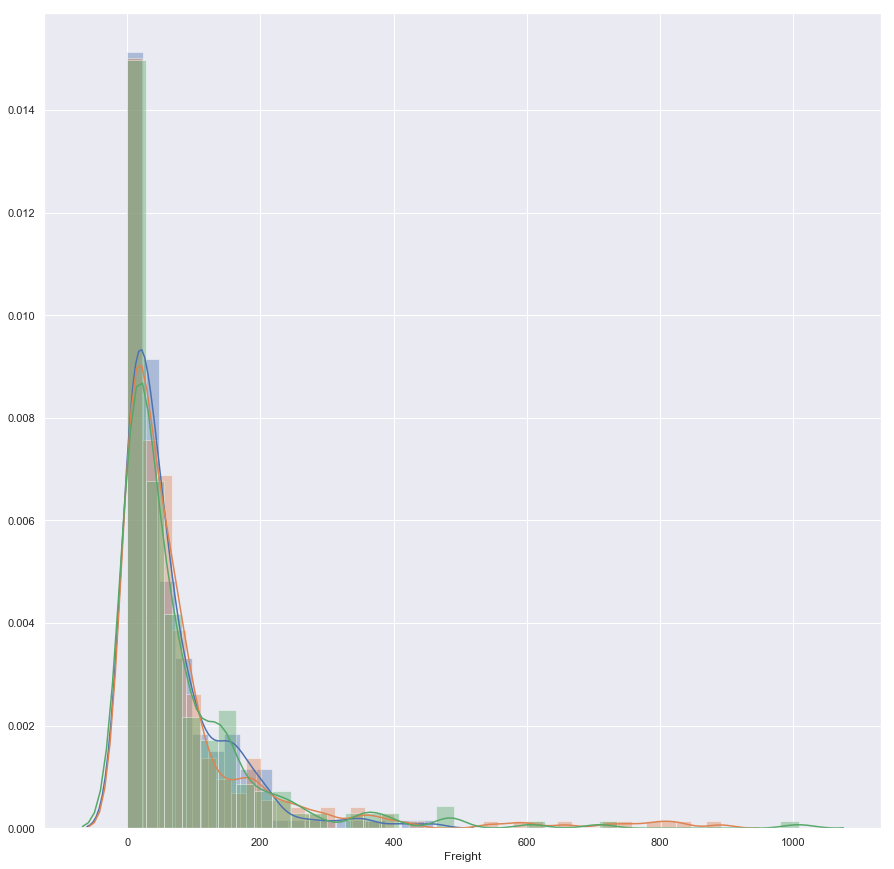

In [370]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(speed_df.Freight)
sns.distplot(united_df.Freight)
sns.distplot(fed_df.Freight)

#### Things learned from the EDA

 - Three different shipping companies. Total of 830;
     1. Federal Shipping : 255
     2. United Package   : 326
     3. Speedy Express   : 249
     
     
 - Quantity data is not normally distributed by looking at the histogram, right scewed.

### Which test to use for hypothesis testing?

Since hypothesis number two has three different groups, and testing if there's any difference between freight cost among them. ANOVA, Analysis of Varaiance might be the right one for this since there're more than two groups. But, there're requirements to meet first in order to use ANOVA. 

#### Assumptions for ANOVA Test
There are three assumptions for ANOVA test. Those are random samples, normal distribution, equal variance.

Let's tackle one at a time to exmaine ANOVA is the right tool.

1. Random sample:

 All the data was independently drawn ones. It's not dependent to each other at all, so It meets the requirements.
 

2. Normal distribution:

 Invoked by Central Limit Theorem.
 
3. Equal variance:

 To test equal variance, there're many ways to test it, but Levne's test is one of the easiest and well kwon method to test. If the p-value is larger than 0.05, then the variances are not significantly different from each other. Let's run it and see if three gorup has equal variance.

In [371]:
scs.levene(speed_df.Freight, united_df.Freight, fed_df.Freight)

LeveneResult(statistic=2.962264195050304, pvalue=0.0522505977506296)

P value is equal to 0.052. The variance between three groups turned out to be not significantly different.

So, it turns out to be ANOVA is the right tool to use for hypothesis number 2!

### Stastical Power

Again, going for the maximum statistical power and confidence level,

$$\alpha = 0.05$$
$$\beta = 0.05$$

Stastical power and confidence level will be both at 95%
In order to verify what sample size is required to have both of the confidence level and stastic power. 

Below is parameters for power analysis.

#### Cohen's d

In [395]:
print('Speedy Express vs United Package %.4f' % Cohen_d(speed_df.Freight,united_df.Freight))
print('SPeedy Express vs Federal Shipping %.4f' % Cohen_d(fed_df.Freight, speed_df.Freight))
print('United Package vs Federal Shipping %.4f' % Cohen_d(united_df.Freight,fed_df.Freight))

Speedy Express vs United Package 0.1877
SPeedy Express vs Federal Shipping 0.1543
United Package vs Federal Shipping 0.0476


In [396]:
# parameters for power analysis
effect_size = 0.0476
alpha = 0.05
power = 0.95
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 11471.470


Smallest effect size was used to calculate required sample size and the result was 11,471. There're only 249 samples available. Lower number of confidence level and statistical power is required. Graphs will be used to find the optimal levels.

In [375]:
united_sample = create_sample_distribution(united_df.Freight)
federal_sample = create_sample_distribution(fed_df.Freight)
speedy_sample = create_sample_distribution(speed_df.Freight)

Looking at the parameters, effect size needs to be calculated.
Cohen's D is for only two groups. All three combinations will be used and smallest effect size number will be used to verify minimum number of the sample size required for the valid test.

Playing around with the number for the Power and confidence level, the minimum sample size maximizing the confidence level and the power level was 243. The smallest data sample is 249, Speedy Express and other two sample has larger sample numbers. So this hypothesis testing will have confidence level of 80% and stastical power of 26% 

$$ \alpha = 0.2$$
$$ \beta = 0.76$$

Now, it is time to draw random samples of 249 from the each sample groups and run the ANOVA test.

In [132]:
sample_fed = fed_df.Freight.sample(244)
sample_speed = speed_df.Freight.sample(244)
sample_united = united_df.Freight.sample(244)

In [133]:
F, p = stats.f_oneway(sample_fed, sample_speed, sample_united)
print('F-value = ', F,'P-value = ', p)

F-value =  1.8771347256286162 P-value =  0.15376685715015367




['Employee_df', 'Category_df', 'Customer_df', 'Shipper_df', 'Supplier_df', 'Order_df', 'Product_df', 'OrderDetail_df', 'CustomerCustomerDemo_df', 'CustomerDemographic_df', 'Region_df', 'Territory_df', 'EmployeeTerritory_df']